# UMAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark
from pyspark.sql import functions as F
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/18 12:18:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/18 12:18:52 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
dct_emb_path = "process/training_cropped_resized_v2/dino_dct/data"
train_path = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
dct_gcs_path = f"{gcs_path}/{dct_emb_path}"
train_gcs_path = f"{gcs_path}/{train_path}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
dct_df.show(n=5, truncate=50)
train_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     dct_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|170e88ca9af457daa1038092479b251c61c64f7d.jpg|   1742956|[-20648.51, 2133.689, -2555.3125, 14820.57, 685...|
|c24a2d8646f5bc7112a39908bd2f6c45bf066a71.jpg|   1356834|[-25395.82, -12564.387, 24736.02, 20483.8, 2115...|
|e1f68e5f05618921969aee2575de20e537e6d66b.jpg|   1563754|[-26178.633, -7670.404, -22552.29, -6563.006, 8...|
|b0433cd6968b57d52e5c25dc45a28e674a25e61e.jpg|   1367432|[-23662.764, -6773.8213, -8283.518, 3769.6064, ...|
|96478a0fe20a41e755b0c8d798690f2c2b7c115f.jpg|   1389010|[-22182.172, -19444.006, 23355.23, 7042.8604, -...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-------------+-------------+---------------+--------------------------------------+----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|     latitude|    longitude|gbif_species_id|                               species|     genus|       family| dataset|  publisher|                                        references|                    

### UMAP plot

In [4]:
# Transformation
grouped_df = (
    dct_df.groupBy("species_id")
    .agg(F.count("species_id").alias("n"))
    .orderBy(F.col("n").desc())
)

# Action
grouped_df.show()

+----------+---+
|species_id|  n|
+----------+---+
|   1369068|823|
|   1360257|793|
|   1737559|770|
|   1741625|700|
|   1414366|674|
|   1743246|668|
|   1737669|662|
|   1363575|653|
|   1394359|653|
|   1359160|642|
|   1358610|638|
|   1356729|636|
|   1358500|634|
|   1356290|632|
|   1360607|630|
|   1400151|627|
|   1357416|626|
|   1394624|625|
|   1722433|625|
|   1359162|624|
+----------+---+
only showing top 20 rows



In [5]:
# Param
num_top_species = 5

# Get top species DF
top_species = [
    int(row["species_id"]) for row in grouped_df.limit(num_top_species).collect()
]
print(f"Top {num_top_species} species ids: {top_species}")

subset_df = dct_df.filter(F.col("species_id").isin(top_species)).select(
    ["image_name", "species_id", "dct_embedding"]
)

subset_df = subset_df.join(train_df, "image_name", "inner").select(
    [subset_df.species_id, train_df.species, subset_df.dct_embedding]
)

subset_df.show(20)
print(subset_df.count())

Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


+----------+--------------------+--------------------+
|species_id|             species|       dct_embedding|
+----------+--------------------+--------------------+
|   1737559|Aria edulis (Will...|[-36971.5, -31.61...|
|   1737559|Aria edulis (Will...|[-27718.117, 7840...|
|   1737559|Aria edulis (Will...|[-30154.316, 1265...|
|   1737559|Aria edulis (Will...|[-15832.229, 3387...|
|   1737559|Aria edulis (Will...|[-31590.842, 3506...|
|   1737559|Aria edulis (Will...|[-5544.543, 24261...|
|   1737559|Aria edulis (Will...|[-28707.459, 7633...|
|   1737559|Aria edulis (Will...|[-27538.91, 32205...|
|   1737559|Aria edulis (Will...|[-32207.602, 1537...|
|   1737559|Aria edulis (Will...|[-14935.598, 2627...|
|   1737559|Aria edulis (Will...|[-25801.566, 3918...|
|   1737559|Aria edulis (Will...|[-23402.393, 2387...|
|   1737559|Aria edulis (Will...|[-27558.389, 3894...|
|   1737559|Aria edulis (Will...|[-30445.197, 3307...|
|   1737559|Aria edulis (Will...|[-20026.209, -541...|
|   173755

3760


In [6]:
from sklearn.preprocessing import StandardScaler

# Convert to Pandas DF
pandas_df = subset_df.select(["dct_embedding", "species"]).toPandas()

# Extract features and labels
emb_df = np.stack(pandas_df["dct_embedding"].values)
scaled_emb = StandardScaler().fit_transform(emb_df)
labels = pandas_df["species"].tolist()

# UMAP reduction
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="euclidean", random_state=42)
embedding = reducer.fit_transform(scaled_emb)  # NumPy array with shape (n_samples, 2)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [7]:
def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 plant species",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=5,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    plt.show()

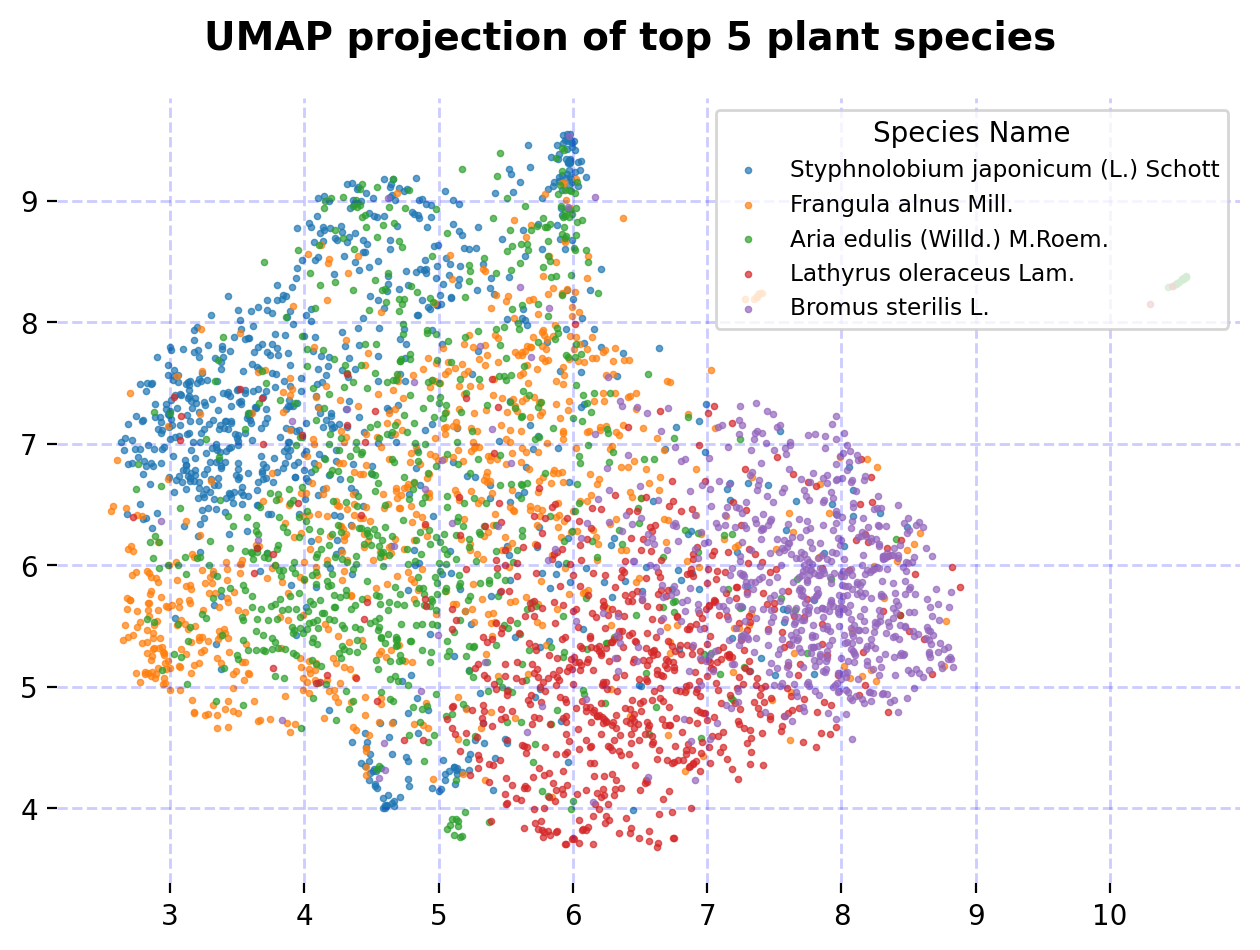

In [8]:
plot_cluster(pandas_df, embedding, algorithm_name="UMAP")

### PaCMAP plot

In [9]:
import pacmap

# PaCMAP
pacmap_embedding = pacmap.PaCMAP(
    n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0
)

# fit the data
pacmap_transformed = pacmap_embedding.fit_transform(scaled_emb, init="pca")

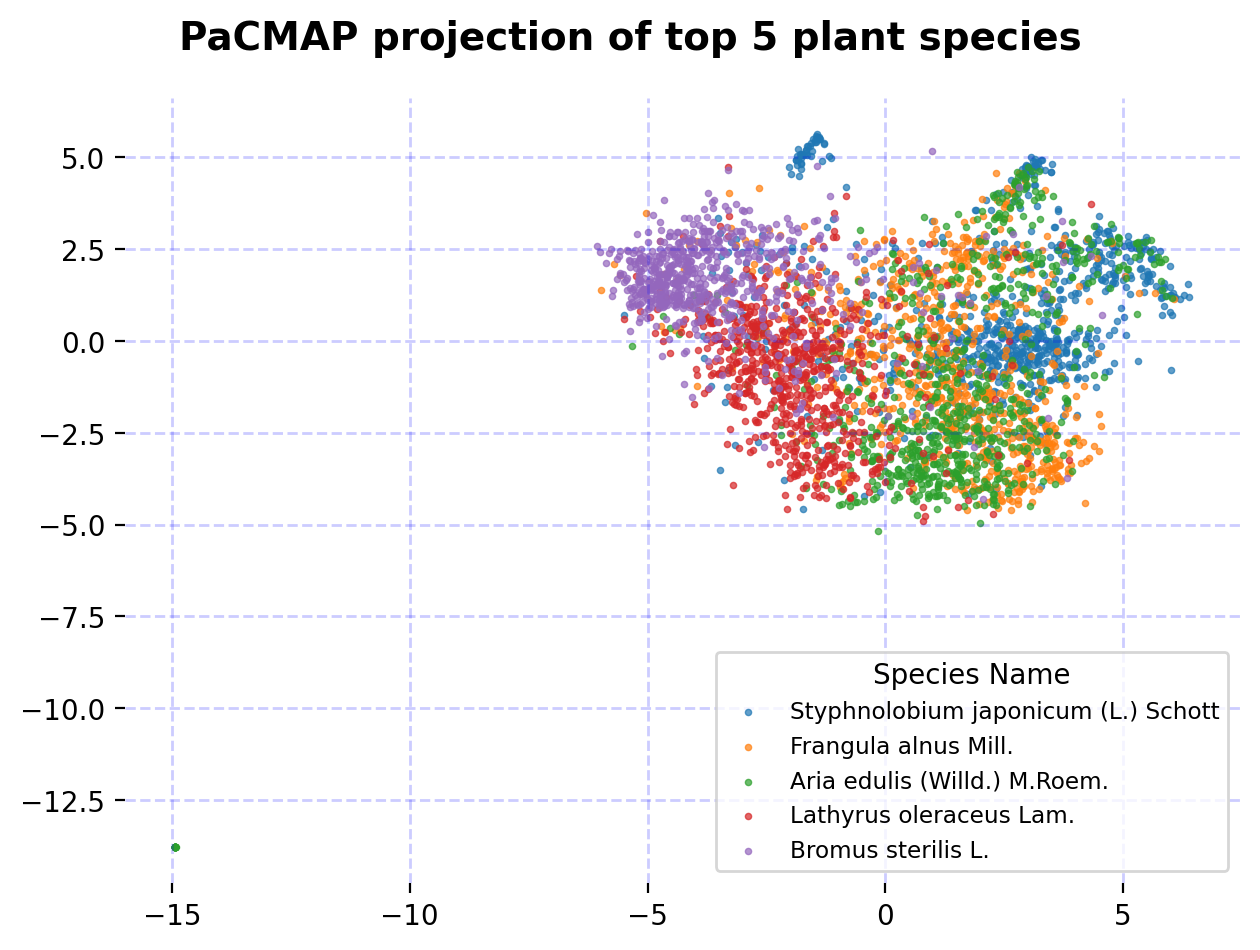

In [10]:
plot_cluster(pandas_df, pacmap_transformed, algorithm_name="PaCMAP")